In [1]:
import functools
from PIL import Image, ImageDraw
import numpy as np, matplotlib.pyplot as plt, matplotlib

import pdb

In [2]:
W = 960; H = 540

In [3]:
def get_coordinates(file_path):
    """
    Reads the coordinates from text file with (y, x) format
    Returns: (list_of_xs, list_of_ys)
    """
    xs = []; ys = [];
    with open(file_path, 'r') as f:
        for line in f:
            y, x = tuple(map(int, line.split()))
            xs.append(x)
            ys.append(y)
    return xs, ys

In [4]:
xs, ys = get_coordinates('../data/DS8.txt')

### 1. Cluster the points in connectivity components

In [5]:
color_map = {}
# {(x, y): color}
cluster_map = {}
# {(x, y): cluster}


# Set the initial values of clusters / colors
for x in range(W):
    for y in range(H):
        color_map[(x, y)] = 0
        cluster_map[(x, y)] = -1

for x, y in zip(xs, ys):
    color_map[(x, y)] = 1
    cluster_map[(x, y)] = -1

In [6]:
def get_neighboors(x, y):
    return [(x-1, y), (x+1, y), (x, y-1), (x, y+1), (x-1, y-1), (x+1, y-1), (x-1, y+1), (x+1, y+1)]

def dfs(x_start, y_start, cluster):
    global color_map, cluster_map
    node_stack = [(x_start, y_start)]
    
    while node_stack:
        x, y = node_stack.pop()
        # Assign cluster to (x, y)
        cluster_map[(x, y)] = cluster
        
        c = color_map.get((x, y))
        assert type(c) == int
        for x_next, y_next in get_neighboors(x, y):
            if ((color_map.get((x_next, y_next)) == c) and (cluster_map.get((x_next, y_next)) == -1)):
                node_stack.append((x_next, y_next))

In [7]:
# Cluster the points into connectivity components using Depth-First-Search algorithm
clusters = set()

for x in range(W):
    for y in range(H):
        if (cluster_map[(x, y)] == -1):
            new_cluster = len(clusters)
            clusters.add(new_cluster)
            dfs(x, y, new_cluster)

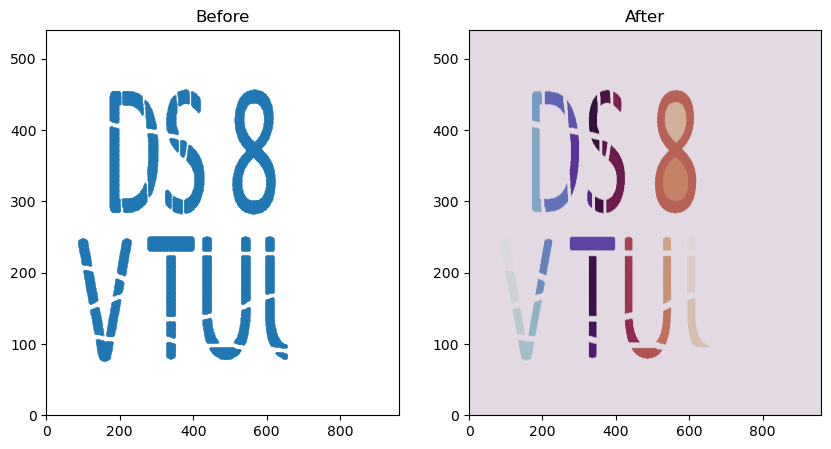

In [8]:
# Plot the clusters
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax.flatten()

colors = list(cluster_map.values())

all_xs = list(map(lambda p: p[0], cluster_map.keys()))
all_ys = list(map(lambda p: p[1], cluster_map.keys()))

ax[0].set_xlim([0, W]); ax[0].set_ylim([0, H])
ax[0].scatter(xs, ys, s=0.1)
ax[0].set_title("Before")

ax[1].set_xlim([0, W]); ax[1].set_ylim([0, H])
ax[1].scatter(all_xs, all_ys, c=colors, s=0.1, cmap="twilight")
ax[1].set_title("After")

plt.show()

In [9]:
print(f"Number of areas: {len(set(cluster_map.values()))}")

Number of areas: 40


### 2. Find the centersof mass for each connectivity component

In [10]:
# Store the clusters of points in more convenient way for calculating the 'center of mass' for each cluste
# { cluster_id: [point1, point2, ...] }
clustered_points = { cluster_id : [] for cluster_id in set(cluster_map.values()) }

for point, cluster_id in cluster_map.items():
    clustered_points[cluster_id].append(np.array(point))

In [11]:
def average(l):
    """ Returns the average of elements in the iterable l """
    # Use the following recursive formula to calculate the average (it helps to avoid BIG numbers in the sum)
    # M_i - average of first i elements 
    # M_n+1 = M_n + 1/(n+1) * (ele_n+1 - M_n) 
    
    # For first i elements: res[0] = average of first i elements; res[1] = i
    return functools.reduce(lambda res, ele: (res[0] + 1/(res[1]+1) * (ele - res[0]), res[1]+1), 
                            l, (0, 0))[0]

In [12]:
Xcs = []   # x-coordinates of centers
Ycs = []   # y-coordinates of centers

for cluster_id, points in clustered_points.items():
    Xc, Yc = average(points)
    Xcs.append(Xc)
    Ycs.append(Yc)

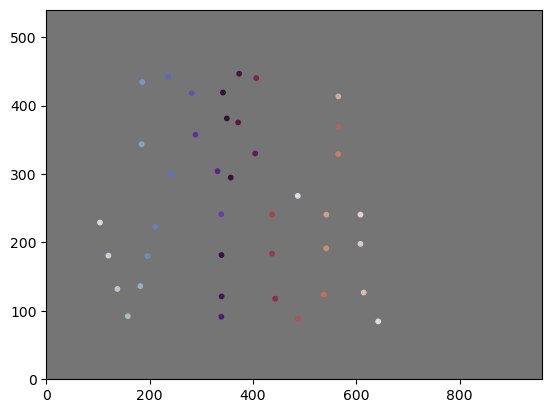

In [13]:
ax = plt.subplot()

ax.set_xlim([0, W]); ax.set_ylim([0, H])
ax.set_facecolor("#757575")
plt.scatter(Xcs, Ycs, s=10, c=range(len(Xcs)), cmap="twilight")

### 3. Build the Voronoi diagram

In [14]:
# The distance function for Voronoi diagram
def d(p1, p2):
    """ Returns the distance between two points """
    return ((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)**0.5

In [15]:
# Just implement a simple O(W*H*n) algorithm, W, H - width and height of image, n - number of centers
voronoi_map = {}

for x in range(W):
    for y in range(H):
        cur_point = (x, y)
        # Find the closest center for current point (x, y)
        voronoi_map[cur_point] = 0
        min_d = d(cur_point, (Xcs[0], Ycs[0])) 
        for i, center in enumerate(zip(Xcs, Ycs)):
            dist = d(cur_point, center)
            if dist < min_d:
                min_d = dist
                voronoi_map[cur_point] = i

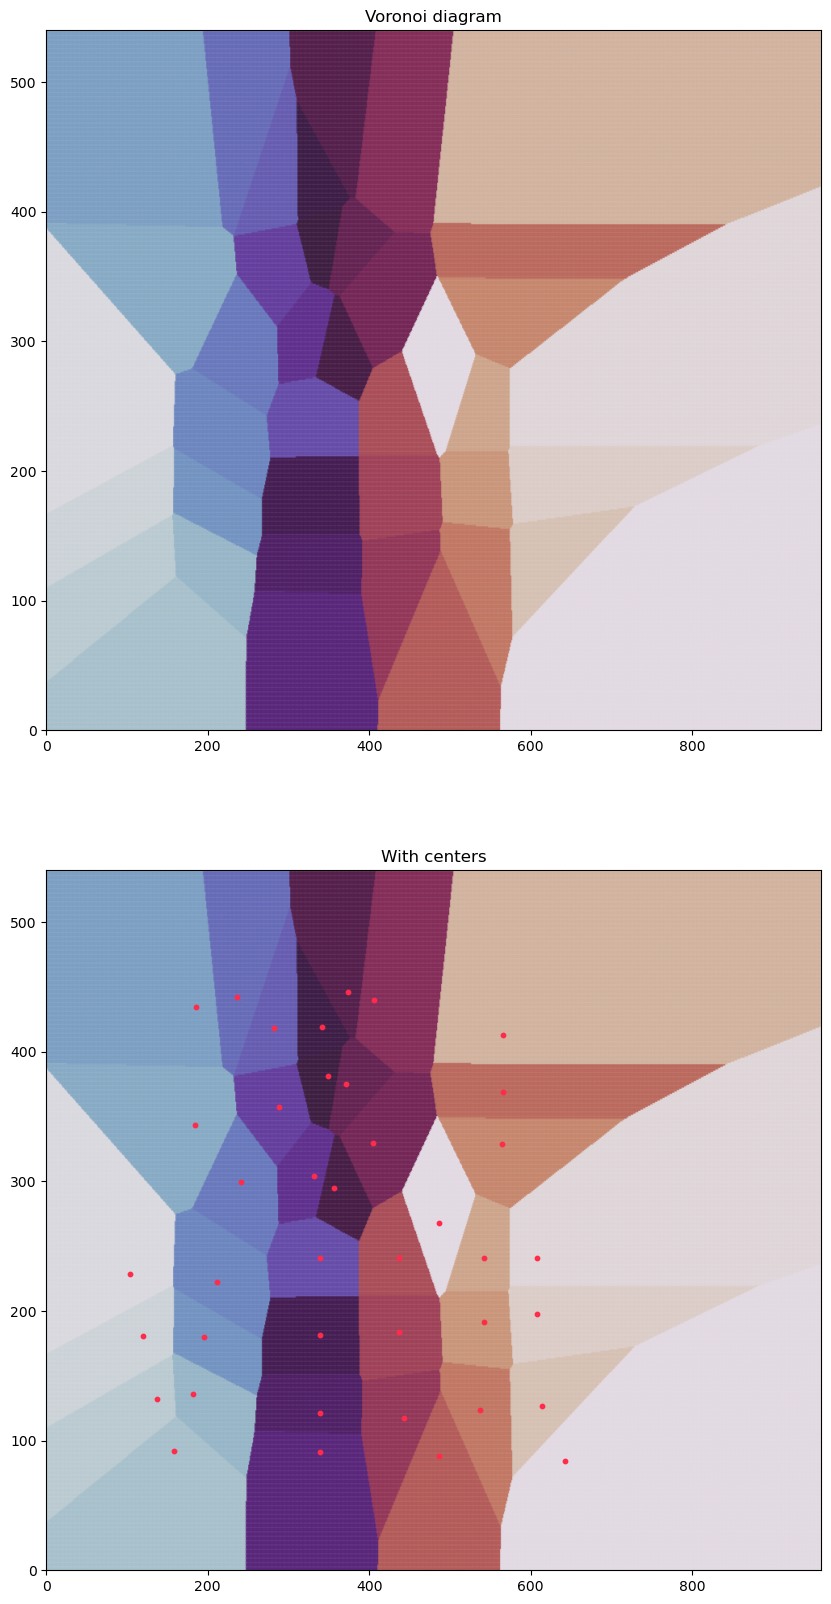

In [16]:
# Plot the Voronoi diagram
fig, ax = plt.subplots(2, 1, figsize=(10, 20))
ax.flatten()

colors = list(voronoi_map.values())

all_xs = list(map(lambda p: p[0], voronoi_map.keys()))
all_ys = list(map(lambda p: p[1], voronoi_map.keys()))

ax[0].set_xlim([0, W]); ax[0].set_ylim([0, H])
ax[0].scatter(all_xs, all_ys, c=colors, s=0.1, cmap="twilight")
ax[0].set_title("Voronoi diagram")

ax[1].set_xlim([0, W]); ax[1].set_ylim([0, H])
ax[1].scatter(all_xs, all_ys, c=colors, s=0.1, cmap="twilight")
ax[1].set_title("With centers")
ax[1].scatter(Xcs, Ycs, s=10, c="#ff2b4b")

plt.show()

### 4. Draw the points as an image

In [20]:
cmap = matplotlib.colormaps["twilight"]
def get_color(cluster_id):
    return matplotlib.colors.to_hex(cmap(cluster_id / (40-1)))

In [21]:
# RGBA mode for transparency
img = Image.new("RGBA", (W, H))
draw = ImageDraw.Draw(img)
img_points = Image.new("RGBA", (W, H), (255, 255, 255, 0))
draw_points = ImageDraw.Draw(img_points)

In [22]:
# Color the areas
for (x, y), cluster_id in voronoi_map.items():
    y = H-1-y
    draw.point((x, y), fill=get_color(cluster_id))
    
# Draw the centers
for i, (x, y) in enumerate(zip(Xcs, Ycs)):
    y = H-1-y
    # For more contrast define color of center like following:
    c = i+6 if i<10 else i-6
    draw.ellipse((x-2.5, y-2.5, x+2.5, y+2.5), fill=get_color(c), outline=None)

In [23]:
# draw initial points with 10% opacity
opacity = int(0.1*255)
for x, y in zip(xs, ys):
    draw_points.point((x, H-1-y), fill=(0, 0, 0, opacity))

In [24]:
out = Image.alpha_composite(img, img_points)

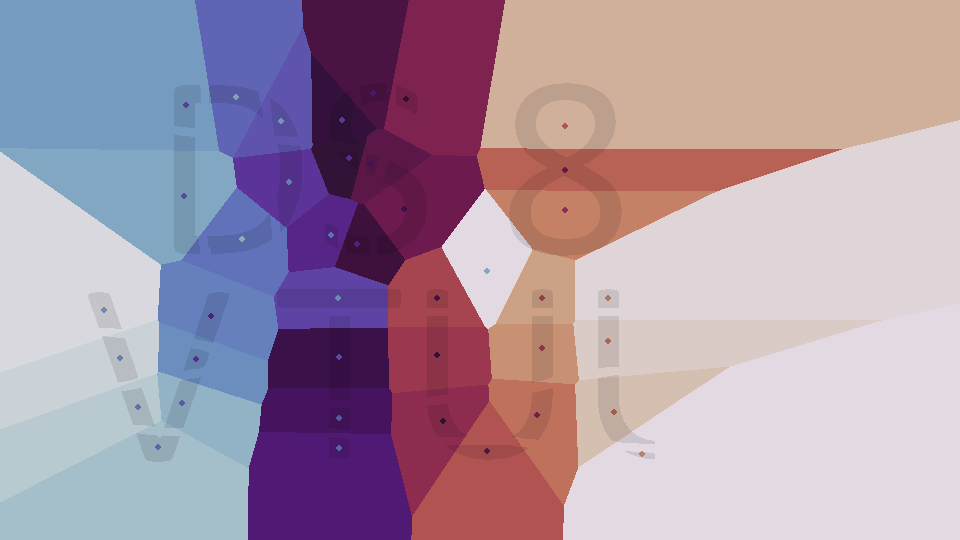

In [25]:
out

In [26]:
out.save("result.png")